# 기본 환경 구성

In [ ]:
from typing import Annotated, TypedDict, List
from langgraph.graph.message import add_messages
from langchain_core.documents import Document
from langchain_openai import ChatOpenAI
from IPython.display import display, Image

class GraphState(TypedDict): 
  context: Annotated[List[Document], add_messages]
  answer: Annotated[List[Document], add_messages]
  question: Annotated[str, "user question"]
  sql_query: Annotated[str, "sql query"]
  binary_score: Annotated[str, "binary score yes or no"]


llm = ChatOpenAI()

# 기본 그래프 생성 

- State 정의 
- 노드 정의 
- 그래프 정의
- 그래프 컴파일 
- 그래프 시각화 

In [ ]:
def retrieve(state: GraphState) -> GraphState: 
  print(f"retrieve : {state}")
  # retrieve 검색 
  documents = "검색된 문서" 
  return GraphState(context=documents, question=state["question"])
  # return {"context": documents} - Dictionary로 GraphState를 이용하거나 Dictionary로 반환해도 상관 없다.

def rewrite_query(state: GraphState) -> GraphState: 
  
  # Query Transform: 쿼리 재작성 
  documents = "검색된 문서" 
  return GraphState(context=documents)

def llm_gpt_execute(state: GraphState) -> GraphState: 
  print(f"llm_gpt_execute : {state}")

  # LLM 실행  
  documents = "GPT의 생성된 답변" 
  return GraphState(context=documents)

def llm_cluade_execute(state: GraphState) -> GraphState: 
  # LLM 실행  
  documents = "Claude의 생성된 답변" 
  return GraphState(context=documents)

def relevance_check(state: GraphState) -> GraphState:
  # Relevance Check: 관련성 확인 
  binary_score = "Relevance Score"
  return GraphState(binary_score=binary_score)

def sum_up(state: GraphState) -> GraphState: 
  # sum_up: 결과 종합 
  answer = "종합된 답변"
  return GraphState(answer=answer)

def search_on_web(state: GraphState) -> GraphState:
  # Search on Web: 웹 검색 
  documents = state["context"] + "기존 문서"
  searched_documents = "검색된 문서"
  documents += searched_documents
  return GraphState(context=documents)

def get_table_info(state: GraphState) -> GraphState:
  # Get Table Info: 테이블 정보 가져오기
  table_info = "테이블 정보"
  return GraphState(context=table_info)

def generate_sql_query(state: GraphState) -> GraphState: 
  # Make SQL Query: SQL 쿼리 생성 
  sql_query = "SQL 쿼리"
  return GraphState(sql_query=sql_query)

def execute_sql_query(state: GraphState) -> GraphState: 
  # Execute SQL Query: SQL 쿼리 실행
  sql_result = "SQL 결과"
  return GraphState(context=sql_result)

def validate_sql_query(state: GraphState) -> GraphState:
  # Validate SQL Query: SQL 쿼리 검증
  binary_score = "SQL 쿼리 검증 결과"
  return GraphState(binary_score=binary_score)

def handle_error(state: GraphState) -> GraphState:
  # 의사결정 
  decision = "결정"
  return decision

def decision(state: GraphState):  
    response = llm.invoke([HumanMessage(
      content=f"""
        LLM아 내가 한 질문의 의미가 실제 도메인에서 요구하는 응답의 범주내에 있냐? 
        있으면 True, 없으면 False 로 반환해 

        질문 : {state["question"]}
        답변 : {state["answer"]}

        도메인의 요구 범위
        {api_call}
        {readis}

        응답포햇: 
        boolean

        다른 값 반환하면 안되!

      """
    )])

    is_right = response.content

    if is_right == "true": 
       return "end"
    else:  
       return "research"

## 그래프 정의

### Conversational Graph

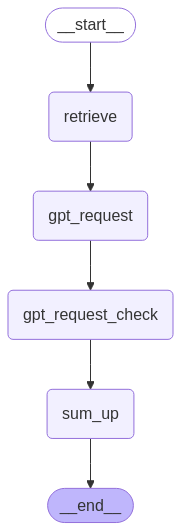

retrieve : {'context': [], 'answer': [], 'question': '안녕?'}
llm_gpt_execute : {'context': [HumanMessage(content='검색된 문서', additional_kwargs={}, response_metadata={}, id='4c89a71c-0e84-4c85-bc12-90a03ce94eb6')], 'answer': [], 'question': '안녕?'}


{'context': [HumanMessage(content='검색된 문서', additional_kwargs={}, response_metadata={}, id='4c89a71c-0e84-4c85-bc12-90a03ce94eb6'),
  HumanMessage(content='GPT의 생성된 답변', additional_kwargs={}, response_metadata={}, id='5cf85b4b-1955-4e5b-86e7-dd795542644c')],
 'answer': [HumanMessage(content='종합된 답변', additional_kwargs={}, response_metadata={}, id='bb88f398-24f7-4f1b-ac42-4576e74f57ed')],
 'question': '안녕?',
 'binary_score': 'Relevance Score'}

In [26]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver 

graph = StateGraph(GraphState)

graph.add_node("retrieve", retrieve)

graph.add_node("gpt_request", llm_gpt_execute)

graph.add_node("gpt_request_check", relevance_check)

graph.add_node("sum_up", sum_up)

graph.add_edge("retrieve", "gpt_request")
graph.add_edge("gpt_request", "gpt_request_check")
graph.add_edge("gpt_request_check", "sum_up")
graph.add_edge("sum_up", END)

graph.set_entry_point("retrieve")

app = graph.compile()

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print("Mermaid 기반 이미지 출력에 실패했습니다. Graphviz PNG 출력으로 대체합니다.")
    display(Image(app.get_graph().draw_png()))

app.invoke({
    "question": "안녕?"
})

### 재검색

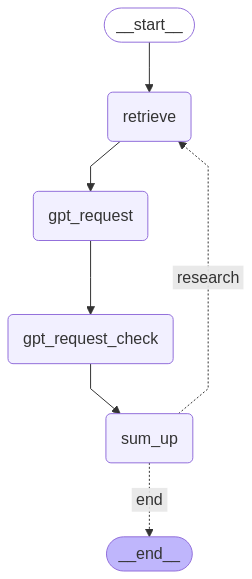

In [9]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver 

graph = StateGraph(GraphState)

graph.add_node("retrieve", retrieve)

graph.add_node("gpt_request", llm_gpt_execute)

graph.add_node("gpt_request_check", relevance_check)

graph.add_node("sum_up", sum_up)

graph.add_edge("retrieve", "gpt_request")
graph.add_edge("gpt_request", "gpt_request_check")
graph.add_edge("gpt_request_check", "sum_up")

graph.add_conditional_edges(
    "sum_up", 
    decision, 
    {
        "research" : "retrieve",
        "end" : END
    }
)

graph.set_entry_point("retrieve")

memory = MemorySaver()

app = graph.compile(checkpointer=memory)

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print("Mermaid 기반 이미지 출력에 실패했습니다. Graphviz PNG 출력으로 대체합니다.")
    display(Image(app.get_graph().draw_png()))

### 멀티 LLM 

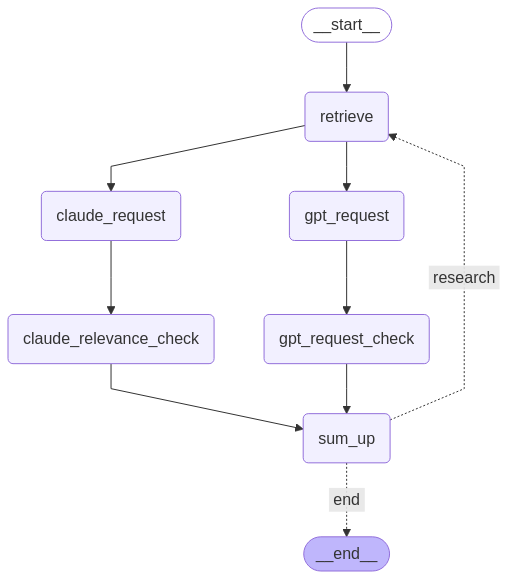

In [11]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver 

graph = StateGraph(GraphState)

graph.add_node("retrieve", retrieve)

graph.add_node("gpt_request", llm_gpt_execute)
graph.add_node("claude_request", llm_cluade_execute)

graph.add_node("gpt_request_check", relevance_check)
graph.add_node("claude_relevance_check", relevance_check)

graph.add_node("sum_up", sum_up)

graph.add_edge("retrieve", "gpt_request")
graph.add_edge("gpt_request", "gpt_request_check")
graph.add_edge("gpt_request_check", "sum_up")
graph.add_edge("retrieve", "claude_request")
graph.add_edge("claude_request", "claude_relevance_check")
graph.add_edge("claude_relevance_check","sum_up")

graph.add_conditional_edges(
    "sum_up", 
    decision, 
    {
        "research" : "retrieve",
        "end" : END
    }
)

graph.set_entry_point("retrieve")

memory = MemorySaver()

app = graph.compile(checkpointer=memory)

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print("Mermaid 기반 이미지 출력에 실패했습니다. Graphviz PNG 출력으로 대체합니다.")
    display(Image(app.get_graph().draw_png()))

### 쿼리 재작성

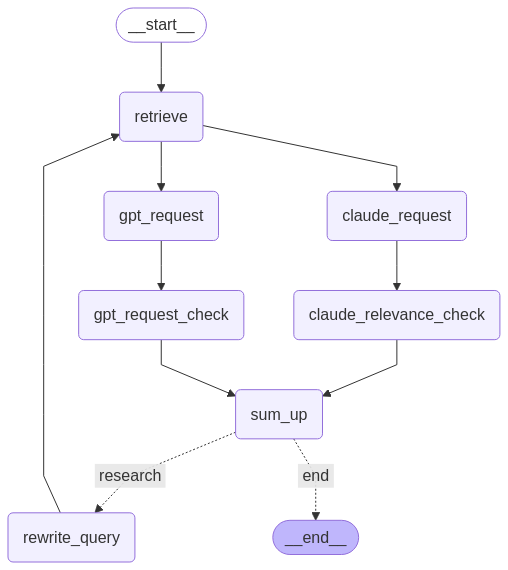

In [27]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver 

graph = StateGraph(GraphState)

graph.add_node("retrieve", retrieve)

graph.add_node("rewrite_query", rewrite_query)

graph.add_node("gpt_request", llm_gpt_execute)
graph.add_node("claude_request", llm_cluade_execute)

graph.add_node("gpt_request_check", relevance_check)
graph.add_node("claude_relevance_check", relevance_check)

graph.add_node("sum_up", sum_up)

graph.add_edge("retrieve", "gpt_request")
graph.add_edge("rewrite_query", "retrieve")
graph.add_edge("gpt_request", "gpt_request_check")
graph.add_edge("gpt_request_check", "sum_up")
graph.add_edge("retrieve", "claude_request")
graph.add_edge("claude_request", "claude_relevance_check")
graph.add_edge("claude_relevance_check","sum_up")

graph.add_conditional_edges(
    "sum_up", 
    decision, 
    {
        "research" : "rewrite_query",
        "end" : END
    }
)

graph.set_entry_point("retrieve")

memory = MemorySaver()

app = graph.compile(checkpointer=memory)

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print("Mermaid 기반 이미지 출력에 실패했습니다. Graphviz PNG 출력으로 대체합니다.")
    display(Image(app.get_graph().draw_png()))